# Projeto Final de Curso

Este projeto usa a linguagem de programação Python e diversas bibliotecas de funções associadas a fim de analizar dados fornecidos pela Secretaria de Segurança Pública do Estado de São Paulo (SSP-SP) e produzir um mapa de calor para a área analisada.

Este projeto tem como motivação mostrar a capacidade de análise de dados do Python e sua aplicação para dados geoespaciais. Os dados e região analisadas foram os seguintes:

- Cidade de São Paulo
    
- Números de furtos de veículos registrados no ano de 2020

### Dados

Os dados para elaboração do mapa de calor são de domínio público, fornecidos pela SSP-SP.

http://www.ssp.sp.gov.br/transparenciassp/Consulta.aspx


Os arquivos de imagem das delimitações municipais são dados públicos fornecidos pelo IBGE.

https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html?=&t=downloads

### Imports Básicos

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import nbconvert
import matplotlib.pyplot as plt
import branca.colormap as cm
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

### Carregamento de Dados

Carregar e formatar dados.

Também serão efetuadas etapas de limpeza e arranjo dos dados, se necessário.

In [2]:
data = gpd.read_file('dados/SP/SP_Municipios_2020.shp')

In [3]:
data.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,3500105,Adamantina,SP,411.987,"POLYGON ((-51.05425 -21.40465, -51.05300 -21.4..."
1,3500204,Adolfo,SP,211.055,"POLYGON ((-49.65795 -21.20333, -49.65645 -21.2..."
2,3500303,Aguaí,SP,474.554,"POLYGON ((-46.97640 -21.96818, -46.97599 -21.9..."
3,3500402,Águas da Prata,SP,142.673,"POLYGON ((-46.73501 -21.81891, -46.73431 -21.8..."
4,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.60614 -22.44173, -46.60347 -22.4..."


### Leitura de Dados

Pode-se obsvervar que um geodataframe (tipo de dado manipulado pela biblioteca geopandas) é praticamente idêntico à qualquer outro dataframe. Porém, o que difere os dois tipos de dataframe é que no primeiro há sempre uma associação de algum objeto geométrico - sejam pontos, áreas, ou linhas - essa categoria "geometria" é definida por diversas propriedades geoespaciais, entre elas as coordenadas e sistema de coordenadas utilizadas.

Estas características são vantajosas para visualização de dados em geodataframes. A biblioteca geopandas tem como dependências o próprio pandas, e também o matplotlib. Com isso, podemos plotar os dados através de métodos internos da biblioteca, como podemos ver a seguir:

<AxesSubplot:>

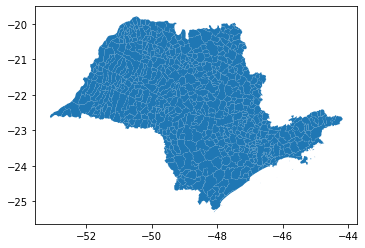

In [4]:
data.plot()

Para os objetivos do projeto, será filtrado a seguinte área específica:

- Município de São Paulo



In [5]:
gdf_sp = data[data['NM_MUN'] == 'São Paulo']

gdf_sp

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
562,3550308,São Paulo,SP,1521.11,"POLYGON ((-46.54624 -23.35791, -46.54585 -23.3..."


<AxesSubplot:>

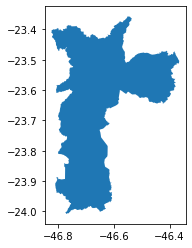

In [6]:
gdf_sp.plot()

Há diversos arquvivos em formatos espaciais, como .KML, .SHP (shapefile) e GeoJSON. O GeoPandas nos permite salvar em qualquer um destes formatos. Para este projeto, será utilizado o GeoJSON, por ser intercambiável com várias outras aplicações.

In [7]:
gdf_sp.to_file('dados/SP/limun_capital.json', driver='GeoJSON')

capital = gpd.read_file('dados/SP/limun_capital.json')

Tendo separado as geometrias necessárias, agora, serão separados os dados dos roubos de veículos. Estes dados são dados para todo o Estado, assim, precisaremos filtrá-los posteriormente para se adequarem à nossa área de estudo.

In [8]:
df_gta = pd.read_excel('dados/SP/DadosBO_2020_12(ROUBO DE VEÍCULOS).xlsx')

df_gta.head()

,ANO_BO,NUM_BO,NUMERO_BOLETIM,BO_INICIADO,BO_EMITIDO,DATAOCORRENCIA,HORAOCORRENCIA,PERIDOOCORRENCIA,DATACOMUNICACAO,DATAELABORACAO,...,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,DESCR_COR_VEICULO,DESCR_MARCA_VEICULO,ANO_FABRICACAO,ANO_MODELO,DESCR_TIPO_VEICULO,QUANT_CELULAR,MARCA_CELULAR
0,2020,1846185,1846185/2020,01/12/2020 00:11:08,01/12/2020 00:11:08,30/11/2020,21:30,A NOITE,30/11/2020,01/12/2020 00:11:08,...,DQY8787,SP,MOGI DAS CRUZES,Cinza,I/HONDA FIT EX,2005.0,NaN,AUTOMOVEL,NaN,NaN
1,2020,1846149,1846149/2020,01/12/2020 00:11:28,01/12/2020 00:11:31,29/11/2020,23:40,A NOITE,30/11/2020,01/12/2020 00:11:28,...,NaN,NaN,NaN,Prata,NaN,NaN,NaN,MOTOCICLO,NaN,NaN
2,2020,1846149,1846149/2020,01/12/2020 00:11:28,01/12/2020 00:11:31,29/11/2020,23:40,A NOITE,30/11/2020,01/12/2020 00:11:28,...,EHA2B71,SP,SÃO VICENTE,Preta,YAMAHA/XT 660R,2009.0,NaN,MOTOCICLO,NaN,NaN
3,2020,5302,5302/2020,30/11/2020 21:35:51,01/12/2020 00:17:52,30/11/2020,19:00,A NOITE,30/11/2020,30/11/2020 21:35:51,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,2020,5302,5302/2020,30/11/2020 21:35:51,01/12/2020 00:17:52,30/11/2020,19:00,A NOITE,30/11/2020,30/11/2020 21:35:51,...,DXX6015,SP,S.PAULO,Preta,RENAULT/CLIO AUT10 16H3P,2007.0,2007.0,AUTOMOVEL,NaN,NaN


Dados carregados adequadamente.

Verificação de dados (se colunas LATITUDE e LONGITUDE estão presentes):

In [9]:
df_gta.columns

Index(['ANO_BO', 'NUM_BO', 'NUMERO_BOLETIM', 'BO_INICIADO', 'BO_EMITIDO',
       'DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA',
       'DATACOMUNICACAO', 'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE',
       'NUMERO_BOLETIM_PRINCIPAL', 'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE',
       'UF', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'EXAME', 'SOLUCAO',
       'DELEGACIA_NOME', 'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA',
       'DESDOBRAMENTO', 'STATUS', 'TIPOPESSOA', 'VITIMAFATAL', 'NATURALIDADE',
       'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE', 'ESTADOCIVIL',
       'PROFISSAO', 'GRAUINSTRUCAO', 'CORCUTIS', 'NATUREZAVINCULADA',
       'TIPOVINCULO', 'RELACIONAMENTO', 'PARENTESCO', 'PLACA_VEICULO',
       'UF_VEICULO', 'CIDADE_VEICULO', 'DESCR_COR_VEICULO',
       'DESCR_MARCA_VEICULO', 'ANO_FABRICACAO', 'ANO_MODELO',
       'DESCR_TIPO_VEICULO', 'QUANT_CELULAR', 'MARCA_CELULAR'],
      dtype='object')

Verificando os valores paras as respectivas colunas:

In [10]:
df_gta[['LATITUDE', 'LONGITUDE']]

,LATITUDE,LONGITUDE
0,-23.555321,-46.250747
1,-23.947593,-46.374177
2,-23.947593,-46.374177
3,-23.564671,-46.418324
4,-23.564671,-46.418324
...,...,...
8520,-23.536885,-46.448319
8521,-23.533970,-46.349213
8522,NaN,NaN
8523,-23.679574,-46.447926


Valores vazios, ou NaN, precisam ser removidos.

In [11]:
df_gta = df_gta.dropna(subset=['LATITUDE', 'LONGITUDE'])

In [12]:
df_gta[['LATITUDE', 'LONGITUDE']]

,LATITUDE,LONGITUDE
0,-23.555321,-46.250747
1,-23.947593,-46.374177
2,-23.947593,-46.374177
3,-23.564671,-46.418324
4,-23.564671,-46.418324
...,...,...
8519,-23.375225,-46.699281
8520,-23.536885,-46.448319
8521,-23.533970,-46.349213
8523,-23.679574,-46.447926


Agora, é necessário construir um GeoDataFrame com os dados acima.
Como explicado anteriormente, um GeoDataFrame é um DataFrame que possui uma coluna de "geometria" associada aos dados. Estes dados, devido a sua natureza, são pontuais - localidades medidas por latitudes e longitudes onde ocorreram os crimes.
Para isso, usaremos a biblioteca Shapely, já associada ao geopandas, para criar estes elementos geometricos de pontos para o dataframe.

In [13]:
df_gta['GEOMETRY'] = None

for index, row in df_gta.iterrows():
    df_gta.loc[index, 'GEOMETRY'] = Point(row.LONGITUDE, row.LATITUDE)

In [14]:
df_gta.head()

,ANO_BO,NUM_BO,NUMERO_BOLETIM,BO_INICIADO,BO_EMITIDO,DATAOCORRENCIA,HORAOCORRENCIA,PERIDOOCORRENCIA,DATACOMUNICACAO,DATAELABORACAO,...,UF_VEICULO,CIDADE_VEICULO,DESCR_COR_VEICULO,DESCR_MARCA_VEICULO,ANO_FABRICACAO,ANO_MODELO,DESCR_TIPO_VEICULO,QUANT_CELULAR,MARCA_CELULAR,GEOMETRY
0,2020,1846185,1846185/2020,01/12/2020 00:11:08,01/12/2020 00:11:08,30/11/2020,21:30,A NOITE,30/11/2020,01/12/2020 00:11:08,...,SP,MOGI DAS CRUZES,Cinza,I/HONDA FIT EX,2005.0,NaN,AUTOMOVEL,NaN,NaN,POINT (-46.2507469989999 -23.5553208699999)
1,2020,1846149,1846149/2020,01/12/2020 00:11:28,01/12/2020 00:11:31,29/11/2020,23:40,A NOITE,30/11/2020,01/12/2020 00:11:28,...,NaN,NaN,Prata,NaN,NaN,NaN,MOTOCICLO,NaN,NaN,POINT (-46.3741774423225 -23.9475925831613)
2,2020,1846149,1846149/2020,01/12/2020 00:11:28,01/12/2020 00:11:31,29/11/2020,23:40,A NOITE,30/11/2020,01/12/2020 00:11:28,...,SP,SÃO VICENTE,Preta,YAMAHA/XT 660R,2009.0,NaN,MOTOCICLO,NaN,NaN,POINT (-46.3741774423225 -23.9475925831613)
3,2020,5302,5302/2020,30/11/2020 21:35:51,01/12/2020 00:17:52,30/11/2020,19:00,A NOITE,30/11/2020,30/11/2020 21:35:51,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,POINT (-46.4183238899259 -23.5646710767407)
4,2020,5302,5302/2020,30/11/2020 21:35:51,01/12/2020 00:17:52,30/11/2020,19:00,A NOITE,30/11/2020,30/11/2020 21:35:51,...,SP,S.PAULO,Preta,RENAULT/CLIO AUT10 16H3P,2007.0,2007.0,AUTOMOVEL,NaN,NaN,POINT (-46.4183238899259 -23.5646710767407)


In [15]:
gdf_gta = gpd.GeoDataFrame(df_gta, geometry='GEOMETRY')

Agora temos um GeoDataFrame. Se plotarmos, teremos a seguinte imagem:

<AxesSubplot:>

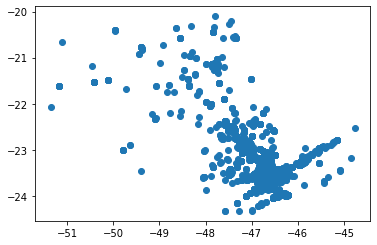

In [16]:
gdf_gta.plot()

Agora, precisamos intereseccionar as duas geometrias.

<AxesSubplot:>

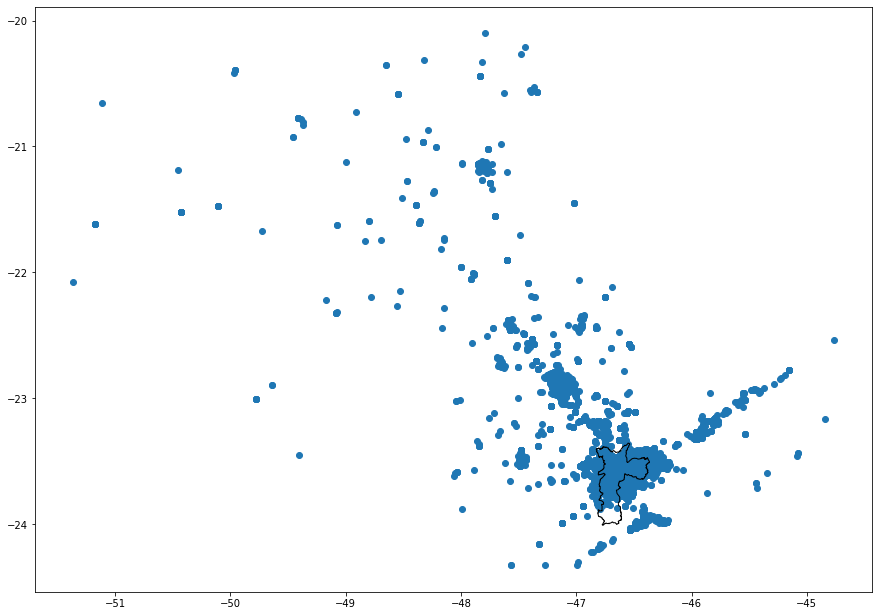

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_gta.plot(ax=ax)
capital.plot(ax=ax, facecolor='None', edgecolor='black')

Agora, isolaremos apenas a poligonal da área do município.

In [18]:
polygon_capital = capital.iloc[0].geometry

Para visualização:

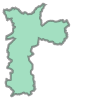

In [19]:
polygon_capital

As duas geometrias sobrepostas - observa-se que os pontos descrevem o contorno do Estado de SP.

Usamos a seguinte operação para a intersecção das geometrias:

In [20]:
gdf_gta_intersect = gdf_gta[gdf_gta.intersects(polygon_capital)]

<AxesSubplot:>

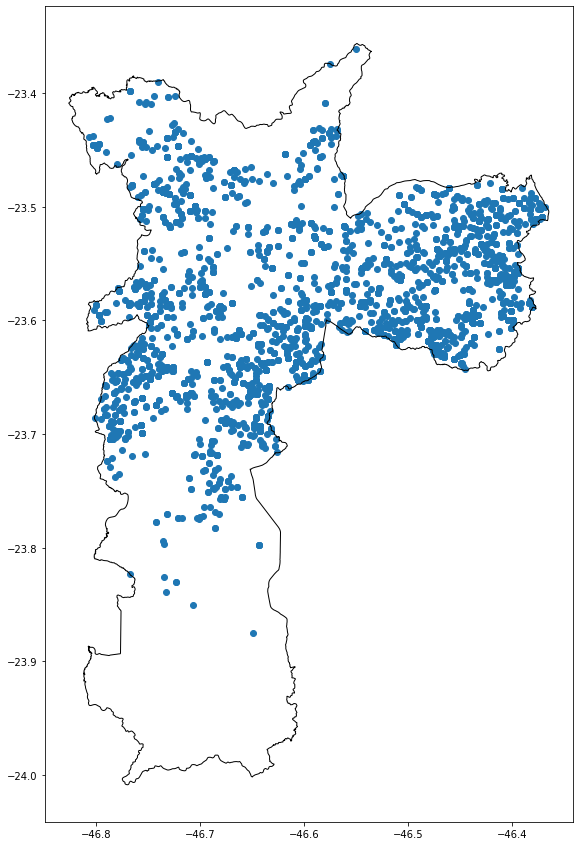

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_gta_intersect.plot(ax=ax)
capital.plot(ax=ax, facecolor='None', edgecolor='black')

Como podemos ver, agora nosso set de pontos está perfeitamente dentro do set da área de estudo. Vamos salvar estas geometrias filtradas também em GeoJSON.

In [22]:
gdf_gta_intersect.to_file('dados/SP/gta_capital.json', driver='GeoJSON')

gdf_gta_capital = gpd.read_file('dados/SP/gta_capital.json')

### Elaborando o mapa

Com os dados tratados, as geometrias filtradas e alinhadas, agora podemos elaborar os mapas através da biblioteca Folium e seus plugins. Ela irá nos permitir elaborar um mapa base, com as características geográficas da área de estudo e seus arredores - nomes, marcos, ruas, etc. Também nos irá permitir sobrepor a este mapa base três principais camadas de visualização de dados:

- Contorno da Área de Estudo

- Mapa de conjunto de pontos (clusters) dos dados

- Mapa de calor dos dados

##### Mapa :

Os dados de latitude e longitude serão centralizados na média dos dados de latitude e longitude do geodataframe em utilização:

In [23]:
lat_mean = gdf_gta_capital['LATITUDE'].mean()
lon_mean = gdf_gta_capital['LONGITUDE'].mean()

base_map = folium.Map(location=[lat_mean, lon_mean], zoom_start=10, tiles='cartodbpositron')

Criando as camadas de visualização:

In [24]:
gta_clusters = FastMarkerCluster(gdf_gta_capital[['LATITUDE', 'LONGITUDE']])

bound = folium.features.GeoJson(capital)

heat_map = HeatMap((gdf_gta_capital[['LATITUDE', 'LONGITUDE']].values),
                  min_opacity=0.2, radius=17, blur=15, max_zoom=1)

Adicionando as camadas ao mapa base:

In [27]:
base_map.add_child(heat_map)
base_map.add_child(gta_clusters)
base_map.add_child(bound)

Resultado final:

In [28]:
base_map

Por fim, basta salvar o mapa em formato .html para uso geral.

In [ ]:
base_map.save('mapas/gta_heat_cluster_SP.html')

## Código de Elaboração:

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

# Criando o GDF do contorno municipal
data = gpd.read_file('dados/SP/SP_Municipios_2020.shp')

gdf_sp = data[data['NM_MUN'] == 'São Paulo']

gdf_sp.to_file('dados/SP/limun_capital.json', driver='GeoJSON')

capital = gpd.read_file('dados/SP/limun_capital.json')

# Criando os pontos dos dados que serão utilizados
df_gta = pd.read_excel('dados/SP/DadosBO_2020_12(ROUBO DE VEÍCULOS).xlsx')

df_gta = df_gta.dropna(subset=['LATITUDE', 'LONGITUDE'])

df_gta['GEOMETRY'] = None

for index, row in df_gta.iterrows():
    df_gta.loc[index, 'GEOMETRY'] = Point(row.LONGITUDE, row.LATITUDE)
    
gdf_gta = gpd.GeoDataFrame(df_gta, geometry='GEOMETRY')

# Intersecção de dados
gdf_gta_intersect = gdf_gta[gdf_gta.intersects(polygon_capital)]

gdf_gta_intersect.to_file('dados/SP/gta_capital.json', driver='GeoJSON')

gdf_gta_capital = gpd.read_file('dados/SP/gta_capital.json')

# Elaboração do mapa
lat_mean = gdf_gta_capital['LATITUDE'].mean()
lon_mean = gdf_gta_capital['LONGITUDE'].mean()

base_map = folium.Map(location=[lat_mean, lon_mean], zoom_start=10)

gta_clusters = FastMarkerCluster(gdf_gta_capital[['LATITUDE', 'LONGITUDE']])
# TODO: colocar popups que deixem claro qual é o crime e alguma outra informação, como o bairro que ocorreu

bound = folium.features.GeoJson(capital)

heat_map = HeatMap((gdf_gta_capital[['LATITUDE', 'LONGITUDE']].values),
                  min_opacity=0.2, radius=17, blur=15, max_zoom=1)

base_map.add_child(heat_map)
base_map.add_child(gta_clusters)
base_map.add_child(bound)

base_map.save('mapas/gta_heat_cluster_SP.html')

## Conclusões

Python é uma linguagem de programação que nos permite, através de um código relativamente simples, elaborar poderosas ferramentas de visualização de dados e utilizar estes resultados para diversos propóstiso.

Por exemplo, diversas inferências poderiam ser realizadas através destes dados de criminalidade - como áreas de prevalência dos crimes, evolução temporal, ou até mesmo, através de métodos de machine learning, previsões para mudança ou extensão da mancha criminal.

Durante a elaboração, foi observado a necessidade de tratamento de dados e o estabelecimento de um método para obter o produto final de maneira direta. Assim, pode-se substituir os dados utilizados por outros quaisquer para a obtenção de um mesmo resultado sem maior necessidade de alterações no código.